# MVTec Metal Nut Classification — Walkthrough

A guided walkthrough covering the same concepts as the steel defect homework,
but on a **different dataset** with a **different model architecture**.
Run every cell, read the comments, and make sure you understand each step
before attempting the homework.

| This Notebook | Homework |
|--------------|----------|
| MVTec metal nut (5 classes) | Steel defect (5 classes) |
| 2 conv blocks (32→64) | 3 conv blocks (32→64→128) |
| 224×224 images | 256×256 images |
| FC: 64→32→classes | FC: 128→64→classes |
| MVTec train/test structure | Flat class directories |

In [1]:
from pathlib import Path
from collections import Counter

import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

print(f"PyTorch {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch 2.10.0+cpu
CUDA available: False


In [2]:
# ── Configuration ─────────────────────────────────────────
# Update this path to where you extracted the MVTec metal_nut dataset
DATA_ROOT = Path("C:/Users/srich/Documents/Python Scripts/anomaly_detection/data/metal_nut")

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 15
LEARNING_RATE = 1e-3
SEED = 42

CLASS_NAMES = ["bent", "color", "flip", "good", "scratch"]
NUM_CLASSES = len(CLASS_NAMES)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CHECKPOINT_PATH = "metal_nut_best.pt"

torch.manual_seed(SEED)
np.random.seed(SEED)

print(f"Device:  {DEVICE}")
print(f"Classes: {CLASS_NAMES}")
print(f"Images:  {IMAGE_SIZE[0]}×{IMAGE_SIZE[1]}")

Device:  cpu
Classes: ['bent', 'color', 'flip', 'good', 'scratch']
Images:  224×224


---
## 1. Data Exploration

The MVTec metal nut dataset has this structure:
```
metal_nut/
├── train/
│   └── good/            ← only normal samples
├── test/
│   ├── good/
│   ├── bent/
│   ├── color/
│   ├── flip/
│   └── scratch/
└── ground_truth/        ← segmentation masks (ignored)
```

We pool **all** images into one list and create our own train/val/test splits
using `train_test_split`. This mirrors the homework workflow.

In [3]:
IMAGE_EXTENSIONS = {".png", ".jpg", ".jpeg", ".bmp", ".tiff"}


def build_file_list(data_root):
    """
    Scan all subdirectories and collect (path, label_index) pairs.

    MVTec nests images under train/ and test/ splits,
    so we walk both and match folder names to CLASS_NAMES.
    """
    data_root = Path(data_root)
    file_list = []

    for split_dir in sorted(data_root.iterdir()):
        if not split_dir.is_dir() or split_dir.name == "ground_truth":
            continue                        # skip masks and files

        for class_dir in sorted(split_dir.iterdir()):
            if not class_dir.is_dir():
                continue
            if class_dir.name not in CLASS_NAMES:
                continue                    # skip unknown folders

            label_idx = CLASS_NAMES.index(class_dir.name)

            for img_path in sorted(class_dir.iterdir()):
                if img_path.suffix.lower() in IMAGE_EXTENSIONS:
                    file_list.append((str(img_path), label_idx))

    return file_list


file_list = build_file_list(DATA_ROOT)
print(f"Total images: {len(file_list)}")

label_counts = Counter(label for _, label in file_list)
for idx, name in enumerate(CLASS_NAMES):
    print(f"  {name:>10s}: {label_counts.get(idx, 0)}")

Total images: 335
        bent: 25
       color: 22
        flip: 23
        good: 242
     scratch: 23


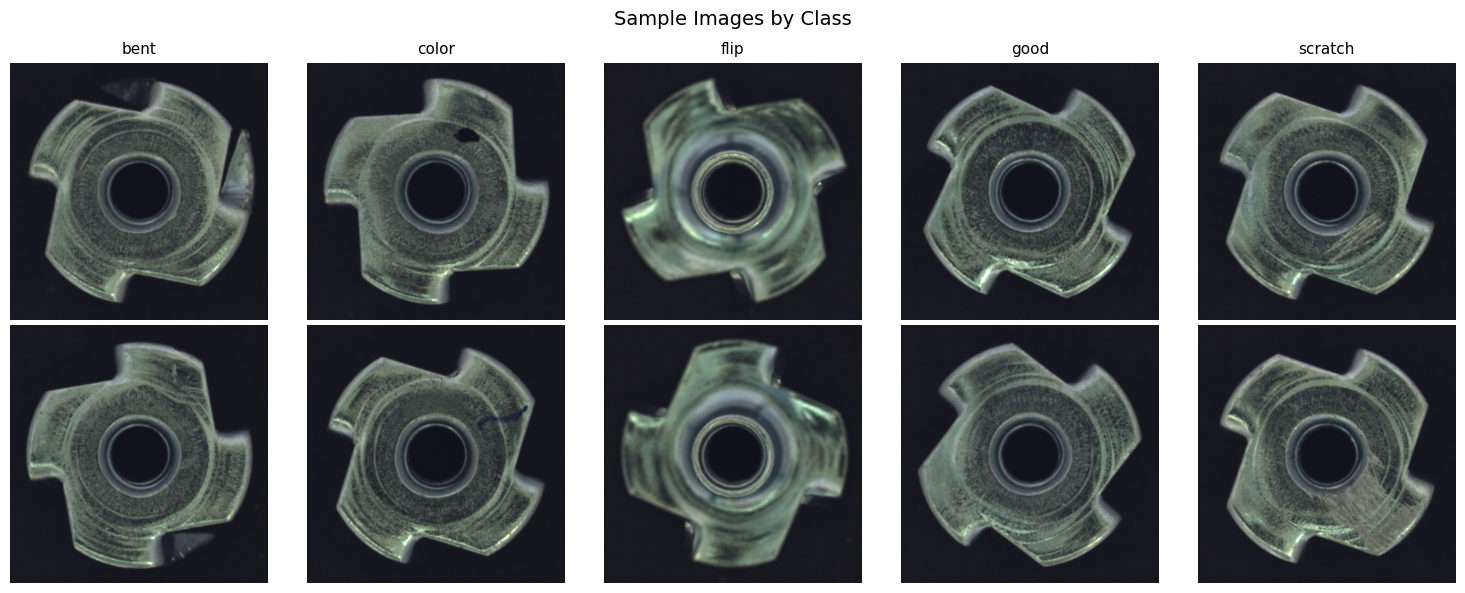

In [4]:
# Visualize a few samples from each class
fig, axes = plt.subplots(2, NUM_CLASSES, figsize=(15, 6))
fig.suptitle("Sample Images by Class", fontsize=14)

for col, (name, label_idx) in enumerate(zip(CLASS_NAMES, range(NUM_CLASSES))):
    class_paths = [p for p, l in file_list if l == label_idx]
    for row in range(2):
        ax = axes[row, col]
        if row < len(class_paths):
            img = cv2.imread(class_paths[row])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax.imshow(img)
        ax.set_title(name if row == 0 else "", fontsize=11)
        ax.axis("off")

plt.tight_layout()
plt.show()

---
## 2. Preprocessing with Albumentations

Two separate pipelines:

- **Training** — includes random augmentation (flips, brightness) to improve generalization
- **Validation** — deterministic (resize + normalize only) so metrics are stable

Both end with **ImageNet normalization** and `ToTensorV2`, which converts
a HWC uint8 NumPy array into a CHW float32 PyTorch tensor.

In [5]:
# ImageNet statistics — standard normalization for models trained on ImageNet.
# Even when training from scratch, these values keep pixel magnitudes
# in a well-conditioned range (~[-2.5, 2.5]) which helps optimization.
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

train_transform = A.Compose([
    A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2(),
])

print("Train pipeline:")
for t in train_transform.transforms:
    print(f"  {t.__class__.__name__}")

print("\nVal pipeline:")
for t in val_transform.transforms:
    print(f"  {t.__class__.__name__}")

Train pipeline:
  Resize
  HorizontalFlip
  RandomBrightnessContrast
  Normalize
  ToTensorV2

Val pipeline:
  Resize
  Normalize
  ToTensorV2


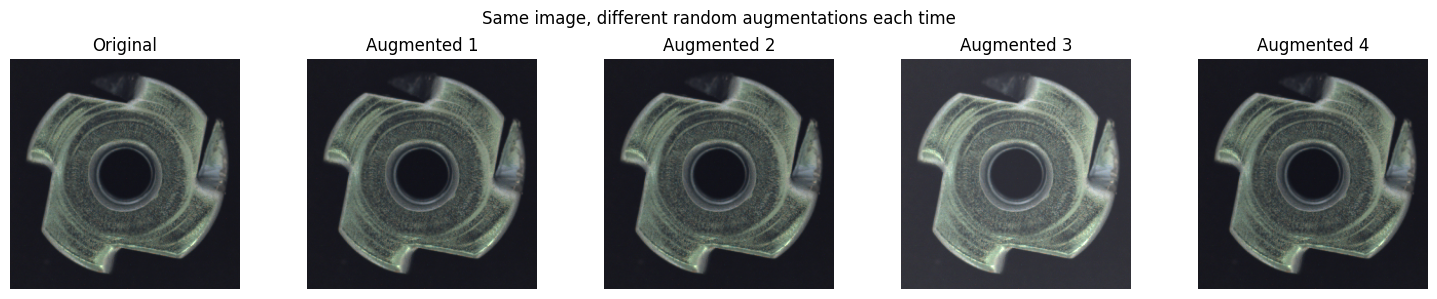

In [6]:
# See what augmentation does — preview WITHOUT normalize so we can display it
aug_preview = A.Compose([
    A.Resize(IMAGE_SIZE[0], IMAGE_SIZE[1]),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
])

sample_img = cv2.cvtColor(cv2.imread(file_list[0][0]), cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
axes[0].imshow(cv2.resize(sample_img, IMAGE_SIZE))
axes[0].set_title("Original")
for i in range(1, 5):
    axes[i].imshow(aug_preview(image=sample_img)["image"])
    axes[i].set_title(f"Augmented {i}")
for ax in axes:
    ax.axis("off")
plt.suptitle("Same image, different random augmentations each time")
plt.tight_layout()
plt.show()

---
## 3. Splitting & DataLoaders

We split the pooled file list into **train / val / test** using
`sklearn.model_selection.train_test_split` with **stratification**,
which ensures each class is proportionally represented in every split.

The split happens in two steps because `train_test_split` produces
two groups at a time:

1. Separate the **test** set from the rest
2. Split the rest into **train** and **val**

In [7]:
labels = [label for _, label in file_list]

TRAIN_RATIO = 0.70
VAL_RATIO   = 0.15
TEST_RATIO  = 0.15

# Step 1: carve off the test set
train_val, test_list = train_test_split(
    file_list,
    test_size=TEST_RATIO,
    stratify=labels,
    random_state=SEED,
)

# Step 2: split the remaining portion into train and val.
# val_ratio relative to the remaining data:
train_val_labels = [label for _, label in train_val]
val_relative = VAL_RATIO / (TRAIN_RATIO + VAL_RATIO)   # e.g. 0.15 / 0.85 ≈ 0.176

train_list, val_list = train_test_split(
    train_val,
    test_size=val_relative,
    stratify=train_val_labels,
    random_state=SEED,
)

print(f"Train: {len(train_list)}  |  Val: {len(val_list)}  |  Test: {len(test_list)}")
print(f"Ratios: {len(train_list)/len(file_list):.2f} / "
      f"{len(val_list)/len(file_list):.2f} / "
      f"{len(test_list)/len(file_list):.2f}")

Train: 233  |  Val: 51  |  Test: 51
Ratios: 0.70 / 0.15 / 0.15


In [8]:
class MetalNutDataset(Dataset):
    """PyTorch Dataset — loads images with OpenCV and applies transforms."""

    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        image_path, label = self.file_list[idx]

        # cv2.imread loads in BGR order — convert to RGB
        image = cv2.imread(image_path)
        if image is None:
            raise RuntimeError(f"Failed to read: {image_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Albumentations expects image= keyword, returns a dict
        if self.transform:
            image = self.transform(image=image)["image"]

        return image, label

In [9]:
train_ds = MetalNutDataset(train_list, transform=train_transform)
val_ds   = MetalNutDataset(val_list,   transform=val_transform)
test_ds  = MetalNutDataset(test_list,  transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

# Inspect one batch
images, labels = next(iter(train_loader))
print(f"Batch shape:  {images.shape}")         # (B, 3, 224, 224)
print(f"Batch dtype:  {images.dtype}")          # float32
print(f"Value range:  [{images.min():.2f}, {images.max():.2f}]")
print(f"Labels:       {labels.tolist()}")

Batch shape:  torch.Size([16, 3, 224, 224])
Batch dtype:  torch.float32
Value range:  [-2.12, 2.64]
Labels:       [3, 3, 3, 3, 3, 3, 4, 1, 3, 3, 3, 3, 3, 3, 3, 3]


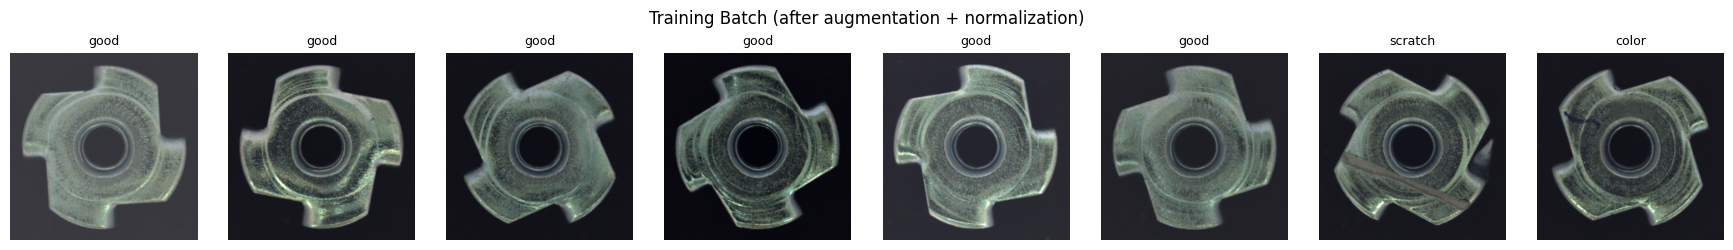

In [10]:
def denormalize(tensor, mean=IMAGENET_MEAN, std=IMAGENET_STD):
    """Reverse ImageNet normalization for display."""
    m = torch.tensor(mean).view(3, 1, 1)
    s = torch.tensor(std).view(3, 1, 1)
    return (tensor * s + m).clamp(0, 1)


n_show = min(8, len(images))
fig, axes = plt.subplots(1, n_show, figsize=(2.2 * n_show, 2.5))
for i in range(n_show):
    img = denormalize(images[i]).permute(1, 2, 0).numpy()
    axes[i].imshow(img)
    axes[i].set_title(CLASS_NAMES[labels[i]], fontsize=9)
    axes[i].axis("off")
plt.suptitle("Training Batch (after augmentation + normalization)")
plt.tight_layout()
plt.show()

---
## 4. Model Architecture

A compact **2-block CNN**. Each block:

```
Conv2d → BatchNorm2d → ReLU → MaxPool2d(2)
```

Followed by `AdaptiveAvgPool2d(1)` which collapses spatial dimensions
to 1×1 regardless of input size, then fully connected layers.

> The homework asks for **3 blocks** with channels 32→64→128.
> This notebook uses only 2 blocks (32→64) — you will need to
> extend the pattern yourself.

In [11]:
class MetalNutCNN(nn.Module):
    """2-block CNN for metal nut classification."""

    def __init__(self, num_classes=NUM_CLASSES):
        super().__init__()      # always call super().__init__() first

        self.features = nn.Sequential(
            # Block 1: 3 input channels → 32 feature maps
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),    # spatial size halved

            # Block 2: 32 → 64
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),    # spatial size halved again
        )

        # Collapse spatial dims: (B, 64, H', W') → (B, 64, 1, 1)
        self.pool = nn.AdaptiveAvgPool2d(1)

        self.classifier = nn.Sequential(
            nn.Flatten(),               # (B, 64, 1, 1) → (B, 64)
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),            # regularization (active only in train mode)
            nn.Linear(32, num_classes),  # output: raw logits, NOT probabilities
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = self.classifier(x)
        return x                        # no softmax here — loss function handles it


model = MetalNutCNN().to(DEVICE)
n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(model)
print(f"\nTrainable parameters: {n_params:,}")

MetalNutCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (pool): AdaptiveAvgPool2d(output_size=1)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=32, out_features=5, bias=True)
  )
)

Trainable parameters: 21,829


In [12]:
# Sanity check: push a dummy batch through and verify output shape
dummy = torch.randn(4, 3, *IMAGE_SIZE).to(DEVICE)
out = model(dummy)
print(f"Input:  {dummy.shape}")    # (4, 3, 224, 224)
print(f"Output: {out.shape}")      # (4, 5) — one logit per class

Input:  torch.Size([4, 3, 224, 224])
Output: torch.Size([4, 5])


---
## 5. Training

The standard PyTorch training loop has this rhythm per batch:

```
optimizer.zero_grad()       # 1. clear old gradients
outputs = model(images)     # 2. forward pass
loss = criterion(outputs, labels)  # 3. compute loss
loss.backward()             # 4. compute gradients (backprop)
optimizer.step()            # 5. update weights
```

Validation is the same forward pass but:
- `model.eval()` switches BatchNorm/Dropout to inference behavior
- `torch.no_grad()` disables gradient tracking (saves memory, faster)
- No optimizer calls (we are observing, not learning)

In [13]:
# CrossEntropyLoss expects:
#   input:  raw logits (B, C)  — NOT softmax probabilities
#   target: integer labels (B,) — NOT one-hot
criterion = nn.CrossEntropyLoss()

# Adam adapts the learning rate per-parameter — good default choice
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [14]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch. Returns (avg_loss, accuracy)."""
    model.train()               # dropout ON, batchnorm uses batch stats
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()               # clear accumulated gradients
        outputs = model(images)             # forward
        loss = criterion(outputs, labels)   # compute loss
        loss.backward()                     # backprop
        optimizer.step()                    # update weights

        running_loss += loss.item()
        _, predicted = outputs.max(1)       # class with highest logit
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / len(loader), correct / total


def validate(model, loader, criterion, device):
    """Evaluate on val/test set. Returns (avg_loss, accuracy)."""
    model.eval()                # dropout OFF, batchnorm uses running stats
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():      # no gradient computation — faster, less memory
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return running_loss / len(loader), correct / total

In [15]:
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
best_val_acc = 0.0

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, DEVICE
    )
    val_loss, val_acc = validate(model, val_loader, criterion, DEVICE)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    # Save checkpoint only when validation accuracy improves
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(
            {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "epoch": epoch,
                "best_val_acc": best_val_acc,
                "num_classes": NUM_CLASSES,
            },
            CHECKPOINT_PATH,
        )
        marker = " ← saved"
    else:
        marker = ""

    print(
        f"Epoch {epoch:2d}/{EPOCHS} | "
        f"train_loss={train_loss:.4f}  train_acc={train_acc:.3f} | "
        f"val_loss={val_loss:.4f}  val_acc={val_acc:.3f}{marker}"
    )

print(f"\nBest validation accuracy: {best_val_acc:.3f}")

Epoch  1/15 | train_loss=1.4212  train_acc=0.562 | val_loss=1.4918  val_acc=0.725 ← saved
Epoch  2/15 | train_loss=1.0818  train_acc=0.721 | val_loss=1.2774  val_acc=0.725
Epoch  3/15 | train_loss=0.9529  train_acc=0.721 | val_loss=1.0411  val_acc=0.725
Epoch  4/15 | train_loss=0.9372  train_acc=0.721 | val_loss=1.1149  val_acc=0.725
Epoch  5/15 | train_loss=0.9638  train_acc=0.721 | val_loss=1.6787  val_acc=0.725
Epoch  6/15 | train_loss=0.9045  train_acc=0.721 | val_loss=1.0083  val_acc=0.725
Epoch  7/15 | train_loss=0.8674  train_acc=0.721 | val_loss=0.9744  val_acc=0.725
Epoch  8/15 | train_loss=0.9007  train_acc=0.721 | val_loss=0.9870  val_acc=0.725
Epoch  9/15 | train_loss=0.8693  train_acc=0.721 | val_loss=0.9634  val_acc=0.725
Epoch 10/15 | train_loss=0.8654  train_acc=0.721 | val_loss=0.9564  val_acc=0.725
Epoch 11/15 | train_loss=0.8586  train_acc=0.721 | val_loss=0.9265  val_acc=0.725
Epoch 12/15 | train_loss=0.8318  train_acc=0.730 | val_loss=1.0640  val_acc=0.725
Epoch 13

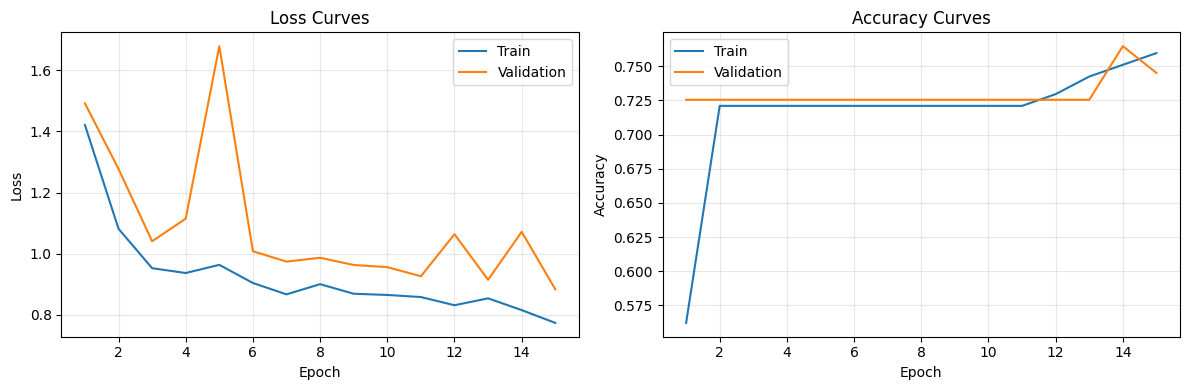

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

epochs_range = range(1, EPOCHS + 1)

ax1.plot(epochs_range, history["train_loss"], label="Train")
ax1.plot(epochs_range, history["val_loss"], label="Validation")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Loss Curves")
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(epochs_range, history["train_acc"], label="Train")
ax2.plot(epochs_range, history["val_acc"], label="Validation")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.set_title("Accuracy Curves")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 6. Evaluation

Load the best checkpoint and evaluate on the held-out **test set**.

The inference pipeline:
1. `torch.load` the checkpoint with `map_location` for device portability
2. `model.load_state_dict(...)` to restore weights
3. `model.eval()` to disable dropout/batchnorm training behavior
4. `F.softmax(logits, dim=1)` to convert raw logits to probabilities

In [17]:
# Load the best checkpoint
checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print(f"Loaded checkpoint from epoch {checkpoint['epoch']}")
print(f"Validation accuracy at save: {checkpoint['best_val_acc']:.3f}")

Loaded checkpoint from epoch 14
Validation accuracy at save: 0.765


In [18]:
# Collect predictions on the test set
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)

        logits = model(images)
        probs = F.softmax(logits, dim=1)
        _, predicted = probs.max(dim=1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

test_acc = (all_preds == all_labels).mean()
print(f"Test accuracy: {test_acc:.3f} ({(all_preds == all_labels).sum()}/{len(all_labels)})")

Test accuracy: 0.784 (40/51)


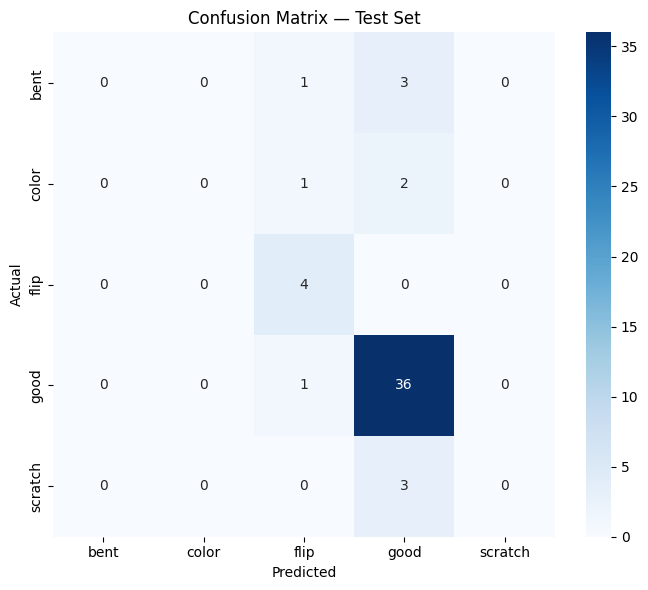

In [19]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=ax,
)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_title("Confusion Matrix — Test Set")
plt.tight_layout()
plt.show()

In [20]:
# Per-class precision, recall, F1
print(classification_report(all_labels, all_preds, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

        bent       0.00      0.00      0.00         4
       color       0.00      0.00      0.00         3
        flip       0.57      1.00      0.73         4
        good       0.82      0.97      0.89        37
     scratch       0.00      0.00      0.00         3

    accuracy                           0.78        51
   macro avg       0.28      0.39      0.32        51
weighted avg       0.64      0.78      0.70        51



C:\ProgramData\Anaconda3\envs\steel-defect\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\ProgramData\Anaconda3\envs\steel-defect\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\ProgramData\Anaconda3\envs\steel-defect\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

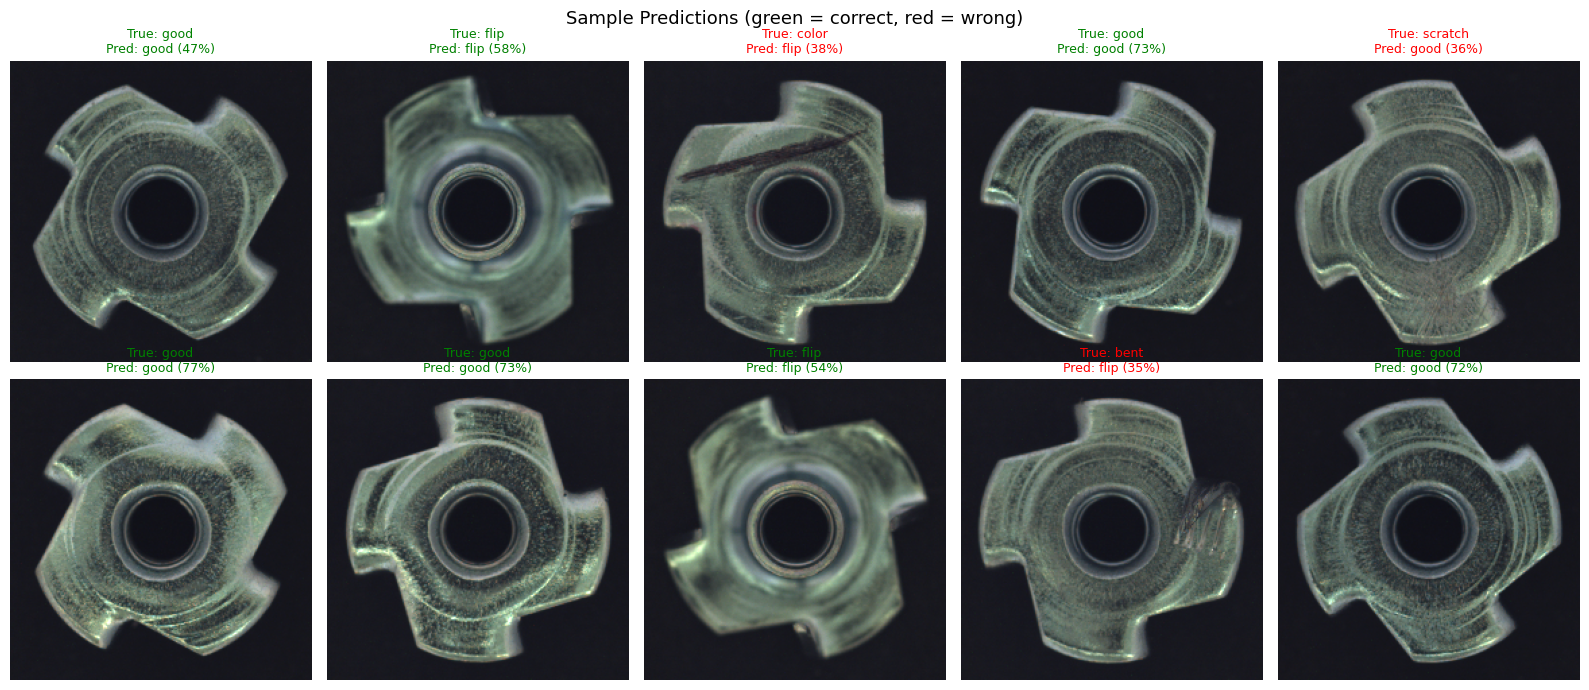

In [21]:
# Visualize sample predictions with confidence
n_samples = min(10, len(test_ds))
indices = np.random.choice(len(test_ds), size=n_samples, replace=False)

rows = 2
cols = min(5, n_samples)
fig, axes = plt.subplots(rows, cols, figsize=(3.2 * cols, 7))

for i, idx in enumerate(indices[:rows * cols]):
    r, c = divmod(i, cols)
    ax = axes[r, c] if rows > 1 else axes[c]

    image, true_label = test_ds[idx]

    with torch.no_grad():
        logits = model(image.unsqueeze(0).to(DEVICE))
        probs = F.softmax(logits, dim=1).squeeze().cpu().numpy()

    pred_idx = probs.argmax()
    correct = pred_idx == true_label

    img_display = denormalize(image).permute(1, 2, 0).numpy()
    ax.imshow(img_display)
    color = "green" if correct else "red"
    ax.set_title(
        f"True: {CLASS_NAMES[true_label]}\n"
        f"Pred: {CLASS_NAMES[pred_idx]} ({probs[pred_idx]:.0%})",
        color=color, fontsize=9,
    )
    ax.axis("off")

plt.suptitle("Sample Predictions (green = correct, red = wrong)", fontsize=13)
plt.tight_layout()
plt.show()

---
## 7. Single-Image Inference Pipeline

This is the pattern the homework's `SteelPredictor.predict()` follows:
load an image, apply val transforms, add a batch dimension, forward pass,
softmax, extract results.

In [22]:
def predict_single(model, image_rgb, transform, device, class_names):
    """
    Classify a single RGB image.

    Args:
        model:       Trained nn.Module in eval mode.
        image_rgb:   NumPy array (H, W, 3), uint8, RGB.
        transform:   Validation transform pipeline.
        device:      torch.device.
        class_names: List of class name strings.

    Returns:
        dict with label, confidence, class_scores, predicted_idx.
    """
    # 1. Preprocess
    tensor = transform(image=image_rgb)["image"]   # (3, H, W) float32
    tensor = tensor.unsqueeze(0).to(device)         # (1, 3, H, W)

    # 2. Forward pass — no gradients needed at inference
    with torch.no_grad():
        logits = model(tensor)                      # (1, num_classes)

    # 3. Postprocess
    probs = F.softmax(logits, dim=1)                # logits → probabilities
    confidence, predicted = probs.max(dim=1)        # highest probability

    pred_idx = predicted.item()                     # tensor → Python int
    conf_val = confidence.item()                    # tensor → Python float

    probs_np = probs.squeeze().cpu().numpy()
    class_scores = {
        name: float(p) for name, p in zip(class_names, probs_np)
    }

    return {
        "label": class_names[pred_idx],
        "confidence": conf_val,
        "class_scores": class_scores,
        "predicted_idx": pred_idx,
    }

In [23]:
# Try it on a random test image
sample_path, sample_label = test_list[np.random.randint(len(test_list))]
sample_img = cv2.cvtColor(cv2.imread(sample_path), cv2.COLOR_BGR2RGB)

result = predict_single(model, sample_img, val_transform, DEVICE, CLASS_NAMES)

print(f"True class:  {CLASS_NAMES[sample_label]}")
print(f"Predicted:   {result['label']}  (confidence: {result['confidence']:.1%})")
print()
print("Class scores:")
for name, score in result["class_scores"].items():
    bar = "█" * int(score * 40)
    print(f"  {name:>10s}  {score:6.1%}  {bar}")

True class:  good
Predicted:   good  (confidence: 68.2%)

Class scores:
        bent    6.2%  ██
       color    7.8%  ███
        flip   11.0%  ████
        good   68.2%  ███████████████████████████
     scratch    6.9%  ██


---
## Recap

| Step | What We Did | Homework Placeholder |
|------|------------|----------------------|
| Directory scanning | `pathlib` iteration, extension filtering, label mapping | DATA-1 |
| Train transforms | `A.Compose` with augmentation + normalize + `ToTensorV2` | PREPROCESS-1 |
| Val transforms | `A.Compose` without augmentation | PREPROCESS-2 |
| Stratified splits | `train_test_split` twice with `stratify` | DATA-3 |
| Dataset class | `cv2.imread`, BGR→RGB, apply transform | DATA-2 |
| CNN architecture | `nn.Sequential` blocks: Conv→BN→ReLU→Pool + FC head | MODEL-1, MODEL-2 |
| Loss + optimizer | `CrossEntropyLoss` + `Adam` | TRAIN-1 |
| Training loop | `zero_grad` → forward → loss → `backward` → `step` | TRAIN-2 |
| Validation loop | `model.eval()` + `torch.no_grad()`, no optimizer calls | TRAIN-3 |
| Checkpointing | `torch.save` state_dict when val_acc improves | TRAIN-4 |
| Load checkpoint | `torch.load` + `load_state_dict` + `eval()` | INFER-1 |
| Single-image predict | transform → unsqueeze → forward → softmax → extract | INFER-2 |

**Key differences from the homework**:
- **2 conv blocks** here vs **3** in homework
- **224×224** here vs **256×256** in homework
- Channel sizes **32→64** here vs **32→64→128** in homework
- FC head **64→32→classes** here vs **128→64→classes** in homework
- Dataset structure differs (MVTec nested splits vs flat class directories)

The *patterns* are identical. If you understand every cell above,
you have everything you need for the homework.